In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
# Rutas del dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/archive'
train_path = os.path.join(dataset_path, 'Training')
test_path = os.path.join(dataset_path, 'Testing')

# Función para cargar imágenes y etiquetas
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder, class_name)
        for filename in os.listdir(class_folder):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                filepath = os.path.join(class_folder, filename)
                image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (128, 128))
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

# Cargar imágenes de entrenamiento y prueba
X_train, y_train = load_images_from_folder(train_path)
X_test, y_test = load_images_from_folder(test_path)


In [ ]:
# Normalizar las imágenes
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convertir imágenes a uint8
X_train = (X_train * 255).astype(np.uint8)
X_test = (X_test * 255).astype(np.uint8)

# Expandir dimensiones
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Convertir etiquetas a one-hot encoding
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [ ]:
# Construir y entrenar el modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
180/180 [==============================] - 73s 393ms/step - loss: 7.4797 - accuracy: 0.6279 - val_loss: 1.8991 - val_accuracy: 0.4594
Epoch 2/10
180/180 [==============================] - 68s 379ms/step - loss: 0.5545 - accuracy: 0.7829 - val_loss: 2.2064 - val_accuracy: 0.6041
Epoch 3/10
180/180 [==============================] - 68s 377ms/step - loss: 0.3941 - accuracy: 0.8610 - val_loss: 2.8580 - val_accuracy: 0.6320
Epoch 4/10
180/180 [==============================] - 71s 396ms/step - loss: 0.2867 - accuracy: 0.8997 - val_loss: 3.0224 - val_accuracy: 0.6802
Epoch 5/10
180/180 [==============================] - 68s 379ms/step - loss: 0.2107 - accuracy: 0.9233 - val_loss: 3.7007 - val_accuracy: 0.6954
Epoch 6/10
180/180 [==============================] - 72s 398ms/step - loss: 0.1702 - accuracy: 0.9460 - val_loss: 3.9513 - val_accuracy: 0.7234
Epoch 7/10
180/180 [==============================] - 70s 387ms/step - loss: 0.1642 - accuracy: 0.9425 - val_loss: 2.8224 - val_ac

In [ ]:
# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Pérdida: {loss:.4f}, Precisión: {accuracy * 100:.2f}%')

13/13 [==============================] - 2s 157ms/step - loss: 4.6741 - accuracy: 0.7437
Pérdida: 4.6741, Precisión: 74.37%


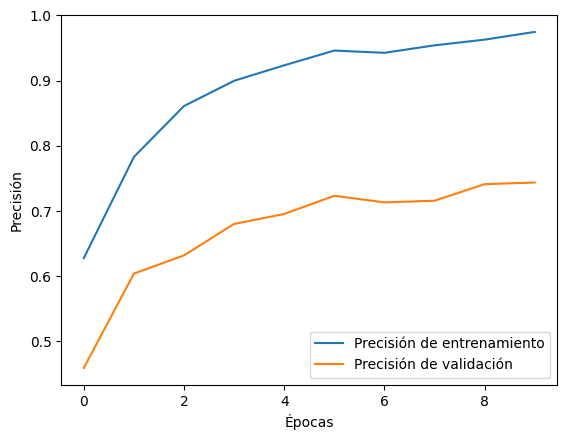

In [ ]:
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [ ]:
# Generar predicciones
predictions = model.predict(X_test)

# Mapear índices de clases a nombres de clases
class_names = ['No Tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']

13/13 [==============================] - 2s 156ms/step


In [ ]:
from sklearn.utils import shuffle

# Mezclar las imágenes y etiquetas
def shuffle_images(X, y):
    X, y = shuffle(X, y, random_state=42)
    return X, y

# Aplicar la mezcla a las imágenes de prueba
X_test_shuffled, y_test_shuffled = shuffle_images(X_test, y_test)

In [ ]:
import random

def plot_sample_images(X, y_true, y_pred, class_names, num_samples_per_class=4):
    plt.figure(figsize=(15, 15))
    num_classes = len(class_names)
    images_and_labels = []

    for class_idx in range(num_classes):
        # Obtener índices de imágenes para esta clase
        class_indices = np.where(np.argmax(y_true, axis=1) == class_idx)[0]

        # Barajar los índices de la clase
        random.shuffle(class_indices)

        # Seleccionar un número fijo de imágenes al azar
        selected_indices = class_indices[:num_samples_per_class]

        # Guardar imágenes y etiquetas
        for idx in selected_indices:
            image = X[idx].reshape(128, 128)
            true_label = class_names[class_idx]
            predicted_label = class_names[np.argmax(y_pred[idx])]
            confidence = np.max(y_pred[idx])

            images_and_labels.append((image, true_label, predicted_label, confidence))

    # Barajar todas las imágenes y etiquetas
    random.shuffle(images_and_labels)

    # Mostrar las imágenes
    for i, (image, true_label, predicted_label, confidence) in enumerate(images_and_labels):
        plt.subplot(num_samples_per_class, num_classes, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

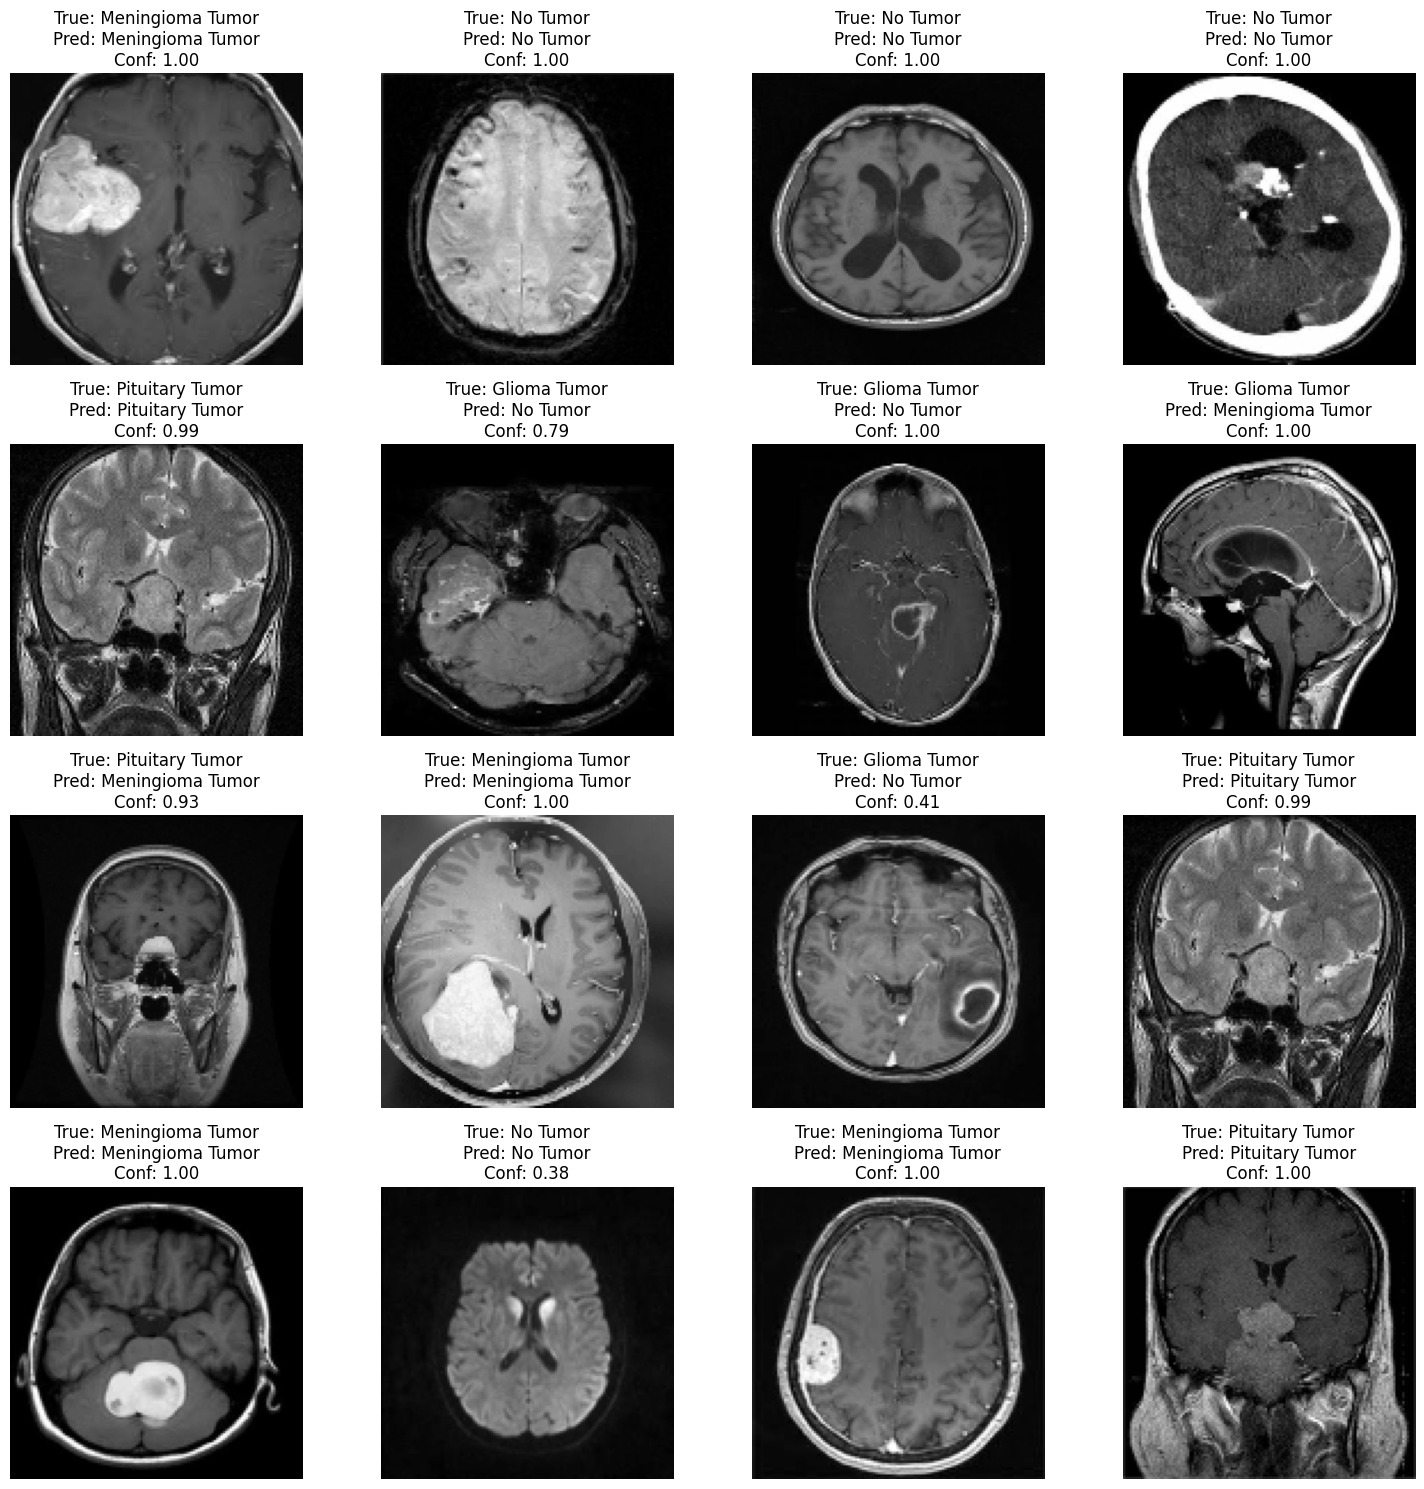

In [ ]:
# Mostrar imágenes aleatorias y mezcladas
plot_sample_images(X_test, y_test, predictions, class_names, num_samples_per_class=4)